# DIFFUSION ANALYSIS

_Rev12 071119 DAL, Physics SFU_

This worksheet demonstrates how to analyze your movies of particle motion and use the mean-squared displacement to calculate the diffusion coefficient $D$ of the particles. 

From the background material on diffusion, we expect that the displacements $d_i = \textrm{position}[i+1] - \textrm{position}[i]$ should be Gaussian random variables with a mean 0 and a variance $2 D \tau$. Your first step should be to calculate $D$ from the variance found by (a) calculation and (b) fitting of a Gaussian function to your histogram. Examples of how to set up a Python notebook to do this can be found in other demo files:
1. Calculating the mean and variance is covered in the anaysis notebook 2.0-Basic-Statistics.ipynb
2. To plot your data as a histogram, please see the demo notebook histogram_demo.ipynb
3. Fitting a model function to your data is demonstrated in the analysis notebook A.1-Example-Fit.ipynb

Then you can use this demo to calculate the diffusion coefficient $D$ from the slope of the graph of the mean-squared displacment as a function of lag time. 

## Load required libraries

In [1]:
# For scientific computing
import numpy as np
import math
from scipy.optimize import curve_fit
# For plotting
import matplotlib.pyplot as plt
# To reduce warnings of little impact 
import warnings 
warnings.filterwarnings("ignore")

## First produce some test data by simulating the motion of the particles

Particles in solution move randomly due to random collisions with other atoms or molecules. This is known as Brownian motion. You will make movies of beads moving in solution to use in these calculations, but we'll just simulate some data to demonstrate the process with. 

We can simulate the motion of the particles by calculating a sequence of positions resulting from random steps. The simulation is idealized: it does not take into account the camera exposure or measurement noise.

In [2]:
# Choose the number of steps to simulate
n_steps = 100

# Set up times using time step dt
dt = 1
t = np.arange(0, n_steps, dt)  

# Set up a vector to store the positions
position = np.zeros(n_steps)

# Loop through each time step, adding a random displacement to the former position
# np.random.randn(1) generates a single number based a "normal" (Gaussian) 
# distribution with mean = 0 and var = 1
for i in range(1, n_steps):
    position[i] = position[i-1] + np.random.randn(1)
# This could be simplified as position = np.cumsum(np.random.randn(n_steps)), 
# but we have chosen to set position[0]=0

Now plot the trajectory to make sure it is reasonable and looks like your data.

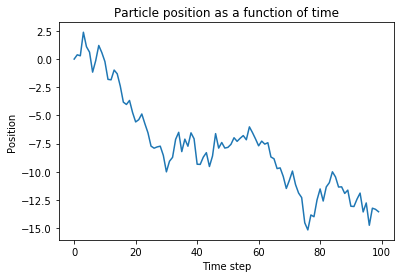

In [3]:
plt.plot(position)
plt.title('Particle position as a function of time')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.show()

## Calculate the MSD

The mean squared displacement (MSD) of the particle at a given lag time $\tau$ is given by $MSD(\tau)=\langle\left[\vec{r}(\tau)−\vec{r}(0)\right]^2\rangle$, where $\vec{r}$ is the vector representing the position of the particle and $\tau$ is the time interval over which the displacement is measured.  

Calculate the MSD as a function of $\tau$ by averaging the squares of displacements over different intervals. If the interval between steps in the trajectory is $dt$, then $\tau = n~dt$ and $MSD(n~dt)=\frac{1}{N-n}\sum^{N-n}_{i=1}\left[x(i+n)-x(i)\right]^2$, where $N$ is the total number of steps.

In [4]:
MSD = np.zeros(n_steps)
for i in range (n_steps):
    dfsq = np.zeros(n_steps-i)
    for j in range (n_steps-i):
        dfsq[j] = (position[j+i] - position[j])**2
    MSD[i] = np.mean(dfsq) 

Plot the result to see what it looks like.

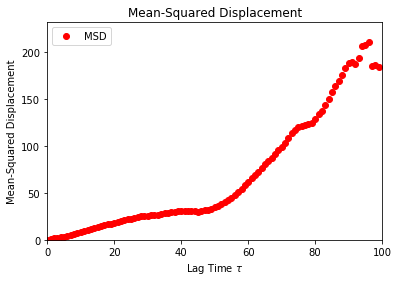

In [5]:
plt.plot(MSD, 'ro', label='MSD')
plt.title('Mean-Squared Displacement')
plt.xlabel('Lag Time ' + r'$\tau$')
plt.ylabel('Mean-Squared Displacement')
plt.axis([0,n_steps,0,max(MSD)*1.1])
plt.legend()
plt.show()

The data is not very linear for this case of a single particle. Note that, at larger lag times $\tau$, the number of data points is small. But it does look pretty good at small lag times - fit a linear function to the first part of the graph.

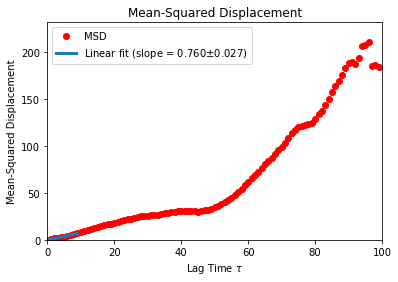

In [6]:
# Fit a line to the first nf points and plot
nf = 10
ftx = np.linspace(0,(nf-1),nf,endpoint=True)  
fty = MSD[:nf]

#Define linear model function
def line(x,m,off): 
    return m*x+off

lopt,lcov = curve_fit(line,ftx,fty, p0=[1,0]) #p0 is initial guess, curve_fit returns parameters and covariance matrix
lerr = np.sqrt(np.diag(lcov)) #error determination from diagonalizing covariance matrix 

xfit = np.linspace(0, (nf-1), nf, endpoint=True)
yfit = line(xfit, *lopt)

plt.plot(MSD, 'ro', label='MSD')
plt.plot(xfit, yfit, linewidth=3, label='Linear fit (slope = ' + str(lopt[0])[:5] + r'$\pm$' + str(lerr[0])[:5] + ')')
plt.title('Mean-Squared Displacement')
#plt.xscale('log')
plt.xlabel('Lag Time ' + r'$\tau$')
#plt.yscale('log')
plt.ylabel('Mean-Squared Displacement')
plt.axis([0,n_steps,0,max(MSD)*1.1])
plt.legend()
plt.show()

## Averaging multiple non-interacting particles

The MSD as a function of lag time does not always yield the linear relationship that we expect a particle moving in 1D.

You can improve the measurement by averaging the MSD of several particles. 

In [7]:
# Perform multiple particle tracks - choose number of particles n_simulations
n_simulations = 10

# Make a new position vector. This will include all simulations.
position_n = np.zeros((n_simulations, n_steps))

# Loop through each simulation.
for i in range(n_simulations):
    # Loop through each step. 
    for j in range(1, n_steps):
        position_n[i, j] = position_n[i, j-1] + np.random.randn(1)

Here we plot the mean position as time evolves as well as the 1-D particle paths.

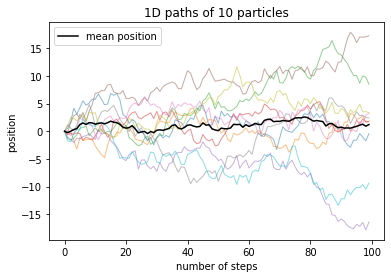

In [8]:
# Plot the paths for all simulations
for i in range(n_simulations):
    plt.plot(position_n[i,:], linewidth=1, alpha=0.5)
    
# Compute the mean position of all particles at each step  
mean_position = np.zeros(n_steps)
for i in range(n_steps):
    mean_position[i] = np.mean(position_n[:, i])
    
# Plot the mean position as a thick black line. 
plt.plot(mean_position, 'k-',label='mean position')

# Add the labels.
plt.title('1D paths of ' + str(n_simulations) + ' particles')
plt.xlabel('number of steps')
plt.ylabel('position')
plt.legend()
plt.show()

As before, we calculate the MSD for each particle.

In [9]:
# Compute the mean squared displacement and the variance for each of the simulated particles
MSD_n = np.zeros((n_simulations,n_steps))
for i in range (n_simulations):
    for j in range (n_steps):
        dfsq = 0
        for k in range (n_steps-j):
            dfsq += (position_n[i,k] - position_n[i,k+j])**2
        MSD_n[i,j] = dfsq/(n_steps-j)    

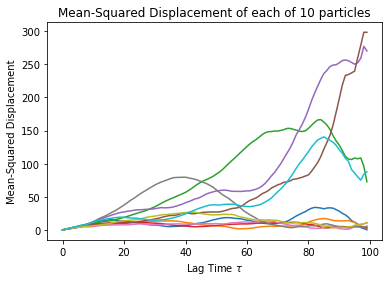

In [10]:
# Now plot them
for i in range(n_simulations):
    plt.plot(MSD_n[i,:])

# Add the labels.
plt.title('Mean-Squared Displacement of each of '+ str(n_simulations) +' particles')
#plt.xscale('log')
plt.xlabel('Lag Time ' + r'$\tau$')
#plt.yscale('log')
plt.ylabel('Mean-Squared Displacement')
plt.show()

Calculate the average of the single particle MSDs, and plot

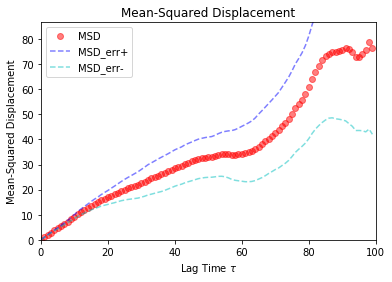

In [11]:
mean_MSD_n=np.mean(MSD_n, axis=0)
stderr_MSD_n=np.sqrt(np.var(MSD_n, axis=0)/n_simulations)

mean_MSD_n_u = mean_MSD_n + stderr_MSD_n
mean_MSD_n_d = mean_MSD_n - stderr_MSD_n

plt.plot(mean_MSD_n, 'ro', alpha=0.5, label='MSD')
plt.plot(mean_MSD_n_u, 'b--', alpha=0.5, label='MSD_err+')
plt.plot(mean_MSD_n_d, 'c--', alpha=0.5, label='MSD_err-')
plt.title('Mean-Squared Displacement')
plt.xlabel('Lag Time ' + r'$\tau$')
plt.ylabel('Mean-Squared Displacement')
plt.axis([0,n_steps,0,max(mean_MSD_n)*1.1])
plt.legend()
plt.show()

In [12]:
nf = 15  #Fitting first nf points
ftx = np.linspace(1,nf,nf,endpoint=True)  #Extracting just nf points for fitting
fty = mean_MSD_n[1:nf+1]   # Exclude MSD(0)
ftyerr = stderr_MSD_n[1:nf+1]

def line(x,m,off): #Define line functional form
    return m*x+off

lopt,lcov = curve_fit(line,ftx,fty, p0=[1,0], sigma=ftyerr, absolute_sigma=True) #p0 is initial guess, curve_fit returns parameters and Cov matrix
lerr = np.sqrt(np.diag(lcov)) #parameter uncertainty determination from diagonal elements of covariance matrix 

xfit = np.linspace(0, (nf-1),nf, endpoint=True)
yfit = line(xfit,*lopt)

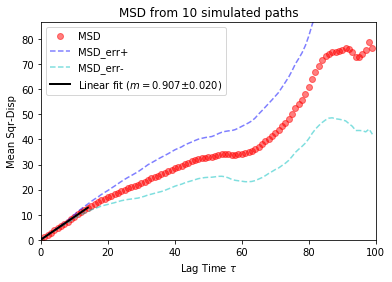

In [13]:
# Plot the mean squared as a function of the number of steps.
plt.plot(mean_MSD_n, 'ro', alpha=0.5, label='MSD')
plt.plot(mean_MSD_n_u, 'b--', alpha=0.5, label='MSD_err+')
plt.plot(mean_MSD_n_d, 'c--', alpha=0.5, label='MSD_err-')

plt.plot(xfit, yfit, 'k-', linewidth=2, label = 'Linear fit (' + r'$m=$' + str(lopt[0])[:5] + r'$\pm$' + str(lerr[0])[:5] + ')')
plt.title('MSD from ' + str(n_simulations) + ' simulated paths')
plt.xlabel('Lag Time ' + r'$\tau$')
#plt.xscale("log")
plt.ylabel('Mean Sqr-Disp')
#plt.yscale("log")
plt.axis([0,n_steps,0,max(mean_MSD_n)*1.1])
plt.legend()
plt.show()

Notice as the number of paths increases (or the number of independent particles used to calculate the MSD), the calculated MSD becomes more linear.  $As~n_{simulations} \rightarrow \infty,~~Slope(MSD) \rightarrow 2D~.$